In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import networkx as nx
from itertools import product
import os
from dtaidistance import dtw
import time
import torch

In [2]:
class TrafficGridAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.traffic_grid = None
        self.zero_indices = None
        self.zero_count = 0

    def load_data(self):
        with h5py.File(self.file_path, 'r') as f:
            for key in f.keys():  # 读取第一个 key 对应的数据
                data = np.array(f[key])  # 转换为 NumPy 数组
                self.traffic_grid = data[0]  # 取第一个通道
                break  # 只读取第一个 key

    def analyze_traffic(self, threshold=30):
        self.zero_indices = np.argwhere(self.traffic_grid < threshold)
        self.zero_count = self.zero_indices.shape[0]
        return self.zero_count, self.zero_indices.tolist()

    def visualize(self):
        # 绘制原始交通网格灰度图
        plt.figure(figsize=(10, 8))
        plt.imshow(self.traffic_grid, cmap='gray')
        plt.title('Original Traffic Network Visualization')
        plt.axis('off')
        plt.show()
        
        # 创建新灰度图矩阵，初始化为255
        visual_grid = np.full_like(self.traffic_grid, 255)
        
        # 将 zero_indices 对应的节点灰度值设置为0
        for row, col in self.zero_indices:
            visual_grid[row, col] = 0
        
        # 绘制提取的交通网络
        plt.figure(figsize=(10, 8))
        plt.imshow(visual_grid, cmap='gray')
        plt.title('Extracted Traffic Network Visualization')
        plt.axis('off')
        plt.show()


In [3]:
class TrafficDataAnalyzer:
    def __init__(self, march_half_filepath, march_filepath):
        self.march_half_filepath = march_half_filepath
        self.march_filepath = march_filepath
        self.Antwerp_traffic_last_half_march = None
        self.Antwerp_traffic_march = None
        self.average_traffic = None
        self.filtered_indices = None
        self.zero_indices = None

    def load_variable(self, filepath):
        """
        从文件中加载变量。
        """
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        return data

    def readdata(self, filepath):
        """
        读取数据文件并转换为 NumPy 数组。
        """
        data = self.load_variable(filepath)
        data = np.array(data)
        print(f"Loaded data shape: {data.shape}")
        return data

    def analyze_traffic(self, zero_indices):
        print('-----------------------------------------------------TrafficDataAnalyzer-----------------------------------------------------')
        # 读取数据
        self.Antwerp_traffic_last_half_march = self.readdata(self.march_half_filepath)
        self.Antwerp_traffic_march = self.readdata(self.march_filepath)
        
        self.zero_indices = zero_indices
        
        # 计算沿时间轴的平均交通流量
        self.average_traffic = np.mean(self.Antwerp_traffic_march, axis=0)
        
        # 排除 zero_indices 中的无连接节点
        for row, col in self.zero_indices:
            self.average_traffic[row, col] = np.nan

        # 计算 30% 和 100% 分位数
        valid_values = self.average_traffic[~np.isnan(self.average_traffic)]
        lower_bound = np.percentile(valid_values, 99.8)
        upper_bound = np.percentile(valid_values, 100)
        
        # 筛选出不在 30%-95% 范围内的节点
        valid_mask = ~np.isnan(self.average_traffic)
        outside_range_mask = (self.average_traffic < lower_bound) | (self.average_traffic > upper_bound)
        filtered_mask = valid_mask & outside_range_mask
        
        # 找到不在范围内的节点索引
        self.filtered_indices = np.argwhere(filtered_mask)
        filtered_count = self.filtered_indices.shape[0]
        
        # 创建 DataFrame 并打印结果
        filtered_df = pd.DataFrame(self.filtered_indices, columns=['Row', 'Column'])
        print(f"Filtered Traffic Indices (Outside {lower_bound}-{upper_bound} Range):")
        print(filtered_df)
        print(f"Total number of filtered traffic nodes: {filtered_count}")
        print(f"30% Percentile (Lower Bound): {lower_bound}")
        print(f"95% Percentile (Upper Bound): {upper_bound}")
        
        # 计算描述性统计信息
        for row, col in self.filtered_indices:
            self.average_traffic[row, col] = np.nan
        
        valid_mask_total = ~np.isnan(self.average_traffic)
        remaining_values = self.average_traffic[valid_mask_total].flatten()
        
        q1 = np.percentile(remaining_values, 25)
        median = np.percentile(remaining_values, 50)
        q3 = np.percentile(remaining_values, 75)
        iqr = q3 - q1
        mean = np.mean(remaining_values)
        min_val = np.min(remaining_values)
        max_val = np.max(remaining_values)
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        print(f"Minimum Value: {min_val}")
        print(f"Q1 (25th Percentile): {q1}")
        print(f"Median (50th Percentile): {median}")
        print(f"Q3 (75th Percentile): {q3}")
        print(f"Maximum Value: {max_val}")
        print(f"Mean: {mean}")
        print(f"Lower Bound (Whisker): {lower_bound}")
        print(f"Upper Bound (Whisker): {upper_bound}")

    def visualize(self):
        # 绘制箱型图
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=self.average_traffic[~np.isnan(self.average_traffic)].flatten())
        plt.title("Boxplot of Average Traffic Flow (Filtered)")
        plt.xlabel("Average Traffic Flow")
        plt.show()
        
        # 创建新的灰度图
        visual_grid = np.full_like(self.average_traffic, 255)
        for row, col in np.vstack((self.zero_indices, self.filtered_indices)):
            visual_grid[row, col] = 0
        
        plt.figure(figsize=(10, 8))
        plt.imshow(visual_grid, cmap='gray')
        plt.title('Filtered Traffic Network Visualization')
        plt.axis('off')
        plt.show()

        print('-----------------------------------------------------TrafficNetworkAnalyzer-----------------------------------------------------')


In [4]:
class TrafficNetworkAnalyzer:
    def __init__(self, average_traffic, zero_indices, filtered_indices):
        self.average_traffic = average_traffic
        self.zero_indices = zero_indices
        self.filtered_indices = filtered_indices
        self.G = nx.DiGraph()  # 无向图改为有向图
        self.G_flat = nx.DiGraph()  # 扁平化后也是有向图
        self.visual_grid = None
        self.filtered_visual_grid = None
        self.rows, self.cols = average_traffic.shape

    def construct_graph(self):
        # 创建灰度图矩阵，初始化为255（白色）
        self.visual_grid = np.full_like(self.average_traffic, 255)
    
        # 将 zero_indices 和 filtered_indices 对应的节点灰度值设为0（黑色，表示不可通行）
        for row, col in self.zero_indices:
            self.visual_grid[row, col] = 0
        for row, col in self.filtered_indices:
            self.visual_grid[row, col] = 0
    
        # 添加节点（只添加可通行区域）
        for r, c in product(range(self.rows), range(self.cols)):
            if self.visual_grid[r, c] == 255:
                self.G.add_node((r, c))

        # 添加**有向**边（8邻域连接）
        for r, c in self.G.nodes():
            neighbors = [
                (r-1, c), (r+1, c), (r, c-1), (r, c+1),  # 上下左右
                (r-1, c-1), (r-1, c+1), (r+1, c-1), (r+1, c+1)  # 对角线方向
            ]
            for nr, nc in neighbors:
                if 0 <= nr < self.rows and 0 <= nc < self.cols and self.visual_grid[nr, nc] == 255:
                    self.G.add_edge((r, c), (nr, nc))  # 直接从 (r, c) 指向邻居 (nr, nc)

        # 找到孤立节点并移除
        isolated_nodes = list(nx.isolates(self.G))
        self.G.remove_nodes_from(isolated_nodes)

        print(f"Number of isolated nodes: {len(isolated_nodes)}")
        print(f"Number of nodes in the directed graph: {len(self.G.nodes())}, number of edges: {len(self.G.edges())}")


    def compute_shortest_paths(self):
        # 计算所有节点对的最短路径长度（最多5阶）
        path_lengths = {node: nx.single_source_shortest_path_length(self.G, node, cutoff=5) for node in self.G.nodes()}
        
        # 5阶内的连接性作为新边添加到图中（方向性维持原样）
        for source, targets in path_lengths.items():
            for target, length in targets.items():
                if length > 0 and length <= 5:
                    self.G.add_edge(source, target)

        # 生成DataFrame
        data = [[node, neighbor, length] for node, neighbors in path_lengths.items() for neighbor, length in neighbors.items()]
        df_paths = pd.DataFrame(data, columns=['Source Node', 'Target Node', 'Path Length'])

        print(f"Number of nodes in the five-step graph: {len(self.G.nodes())}, number of edges: {len(self.G.edges())}")

    def filter_connected_nodes(self):
        # 重新构造 visual_grid，只保留连通的节点
        self.filtered_visual_grid = np.full_like(self.visual_grid, 0)  # 先设为黑色
        for r, c in self.G.nodes():
            self.filtered_visual_grid[r, c] = 255  # 仅保留非孤立节点

        # 绘制最终的灰度图
        plt.figure(figsize=(10, 8))
        plt.imshow(self.filtered_visual_grid, cmap='gray')
        plt.title('Filtered Traffic Network Without Isolated Nodes')
        plt.axis('off')
        plt.show()

        # 提取所有连通节点的交通流数据
        connected_traffic_values = [self.average_traffic[r, c] for r, c in self.G.nodes()]

        # 计算统计信息
        q1 = np.percentile(connected_traffic_values, 25)  # 下四分位数（Q1）
        q3 = np.percentile(connected_traffic_values, 75)  # 上四分位数（Q3）
        median = np.median(connected_traffic_values)  # 中位数（Q2）
        mean = np.mean(connected_traffic_values)  # 均值
        min_val = np.min(connected_traffic_values)  # 最小值
        max_val = np.max(connected_traffic_values)  # 最大值

        # 打印统计信息
        print(f"  Average Traffic Flow Statistics for Connected Nodes:")
        print(f"  Minimum: {min_val:.2f}")
        print(f"  Q1 (25th percentile): {q1:.2f}")
        print(f"  Median (Q2, 50th percentile): {median:.2f}")
        print(f"  Mean: {mean:.2f}")
        print(f"  Q3 (75th percentile): {q3:.2f}")
        print(f"  Maximum: {max_val:.2f}")

        # 绘制箱型图
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=connected_traffic_values, color='lightblue')
        plt.title('Box Plot of Traffic Flow for Connected Nodes')
        plt.ylabel('Average Traffic Flow (Vehicle / Day)')
        plt.grid(True, linestyle='--', alpha=0.6)
    
        plt.show()



    def flatten_graph(self):
        def to_flat_index(r, c, cols):
            return r * cols + c

        # 创建新的扁平化后的有向图
        self.G_flat = nx.DiGraph()
        
        # 添加扁平化后的节点
        for node in self.G.nodes():
            flat_index = to_flat_index(node[0], node[1], self.cols)
            self.G_flat.add_node(flat_index)
        
        # 添加扁平化后的有向边
        for u, v in self.G.edges():
            u_flat = to_flat_index(u[0], u[1], self.cols)
            v_flat = to_flat_index(v[0], v[1], self.cols)
            self.G_flat.add_edge(u_flat, v_flat)

        # ✅ 添加自环（每个节点连接到自己）
        for node in self.G_flat.nodes():
            self.G_flat.add_edge(node, node)
        
        print(f"Number of nodes after flattened: {len(self.G_flat.nodes())}")
        print(f"Number of edges after flattened: {len(self.G_flat.edges())}")
        print('-----------------------------------------------------TrafficDataProcessor-----------------------------------------------------')
        
        return self.G_flat  # 返回完整的 networkx 有向图


In [5]:
class TrafficDataProcessor:
    def __init__(self, data, aux_data, G_flat):
        """
        :param data: 主要用于训练的数据
        :param aux_data: 用于计算 DTW 静态加权图的数据
        :param G_flat: 经过扁平化的路网图
        """
        self.data = data
        self.aux_data = aux_data  # 新增辅助数据
        self.G_flat = G_flat
        self.valid_nodes = sorted(list(G_flat.nodes()))  # 经过扁平化的有效节点
        self.filtered_data = None
        self.filtered_aux_data = None
        self.G_dtw_static = None  # 存储静态 DTW 图

    def filter_and_flatten(self):
        """
        过滤数据，仅保留 G_flat 中的节点，转换形状 (time_steps, num_valid_nodes)。
        """
        time_steps = self.data.shape[0]
        aux_time_steps = self.aux_data.shape[0]

        # 主要数据展平成 (time_steps, num_rows*num_cols)
        data_flat = self.data.reshape(time_steps, -1)
        self.filtered_data = data_flat[:, self.valid_nodes]  # 只保留有效节点

        # 辅助数据展平成 (aux_time_steps, num_rows*num_cols)
        aux_data_flat = self.aux_data.reshape(aux_time_steps, -1)
        self.filtered_aux_data = aux_data_flat[:, self.valid_nodes]  # 只保留有效节点

        print(f"Shape after filtering - Main Data: {self.filtered_data.shape}, Aux Data: {self.filtered_aux_data.shape}")
        return self.filtered_data, self.filtered_aux_data, self.valid_nodes

    def compute_static_dtw_graph(self):
        """
        计算基于 `self.filtered_aux_data` 的 **静态 DTW 加权图**，仅计算一次。
        """
        if self.filtered_aux_data is None:
            raise ValueError("Please call filter_and_flatten() first!")

        self.G_dtw_static = self.G_flat.copy()  # 复制 G_flat
        
        print("Computing static DTW weights...")

        # 计算所有边的 DTW 距离
        for edge_idx, (u, v) in enumerate(self.G_dtw_static.edges(), start=1):
            start_time = time.time()  # 记录起始时间

            dtw_distance = dtw.distance(
                self.filtered_aux_data[:, self.valid_nodes.index(u)].astype(np.float32),
                self.filtered_aux_data[:, self.valid_nodes.index(v)].astype(np.float32)
            )
            self.G_dtw_static[u][v]['weight'] = dtw_distance

            end_time = time.time()  # 记录结束时间
            elapsed_time = end_time - start_time  # 计算时间

            # 每条边计算完成后打印信息
            print(f"Edge {edge_idx} processed, Time: {elapsed_time:.4f} sec")

        print("Static DTW graph computed.")
        return self.G_dtw_static

    def save_sliding_window(self, save_dir, history_size=6, forecast_size=6):
        """
        生成滑动窗口数据，使用 **静态 DTW 图** 而不在每个窗口计算 DTW。
        """
        if self.filtered_data is None or self.G_dtw_static is None:
            raise ValueError("Please call filter_and_flatten() and compute_static_dtw_graph() first!")

        time_steps, num_valid_nodes = self.filtered_data.shape
        num_samples = time_steps - history_size - forecast_size + 1

        os.makedirs(save_dir, exist_ok=True)

        X_all = []
        Y_all = []

        for i in range(num_samples):
            start_time = time.time()

            # 取 [i, i+history_size) 这段做X
            hist_data = self.filtered_data[i : i + history_size, :]
            # 取 [i+history_size, i+history_size+forecast_size) 这段做Y
            fut_data = self.filtered_data[i + history_size : i + history_size + forecast_size, :]

            X_all.append(hist_data)
            Y_all.append(fut_data)

            end_time = time.time()
            print(f"Sliding window {i+1}/{num_samples} generated, cost: {end_time - start_time:.4f} sec")

        # 转换为 NumPy 数组
        X_all = np.array(X_all, dtype=np.float32)
        Y_all = np.array(Y_all, dtype=np.float32)

        # # 保存数据
        # np.save(os.path.join(save_dir, "X.npy"), X_all)
        # np.save(os.path.join(save_dir, "Y.npy"), Y_all)

        # # 保存 **静态 DTW 加权图**
        # with open(os.path.join(save_dir, "DTW_graphs.pkl"), 'wb') as f:
        #     pickle.dump(self.G_dtw_static, f)

        print(f"Data saved at '{save_dir}', shape: X {X_all.shape}, Y {Y_all.shape}.")
        print(f"Saved 1 static DTW graph.")

        return self.G_dtw_static


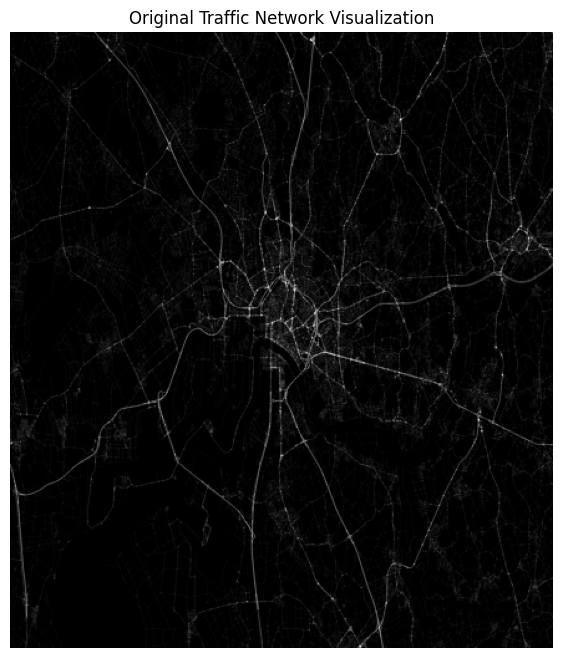

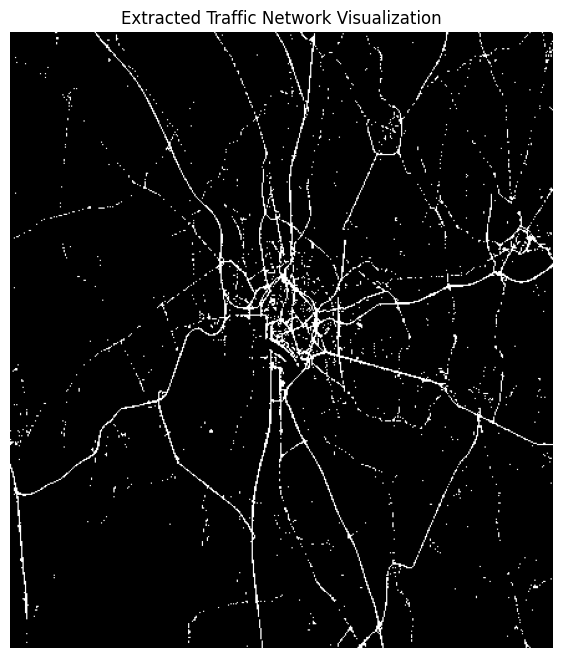

Zero Count: 207289
Loaded data shape: (720, 495, 436)
-----------------------------------------------------TrafficDataAnalyzer-----------------------------------------------------
Loaded data shape: (720, 495, 436)
Loaded data shape: (720, 495, 436)
Filtered Traffic Indices (Outside 42.6704166666672-104.5 Range):
      Row  Column
0       0      36
1       0      37
2       0      68
3       0     164
4       0     213
...   ...     ...
8508  494     281
8509  494     282
8510  494     299
8511  494     414
8512  494     417

[8513 rows x 2 columns]
Total number of filtered traffic nodes: 8513
30% Percentile (Lower Bound): 42.6704166666672
95% Percentile (Upper Bound): 104.5
Minimum Value: 42.733333333333334
Q1 (25th Percentile): 45.11527777777778
Median (50th Percentile): 51.34236111111112
Q3 (75th Percentile): 56.689236111111114
Maximum Value: 104.5
Mean: 55.242978395061726
Lower Bound (Whisker): 27.75434027777777
Upper Bound (Whisker): 74.05017361111112


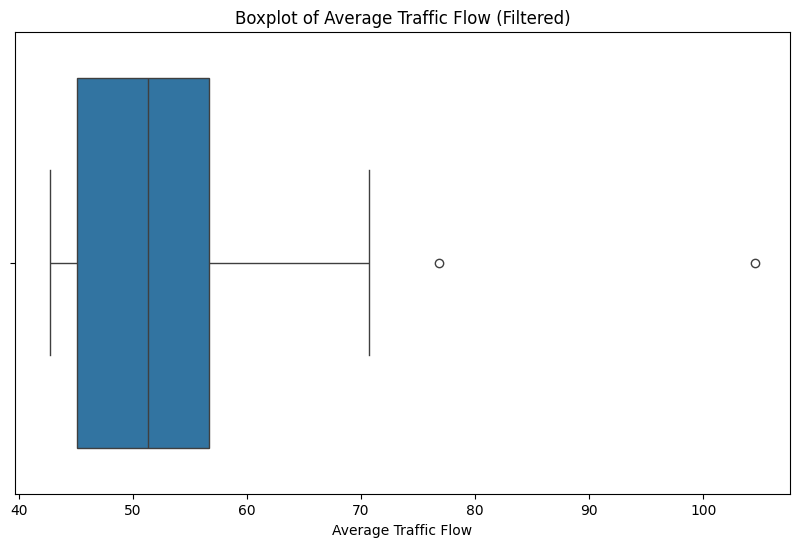

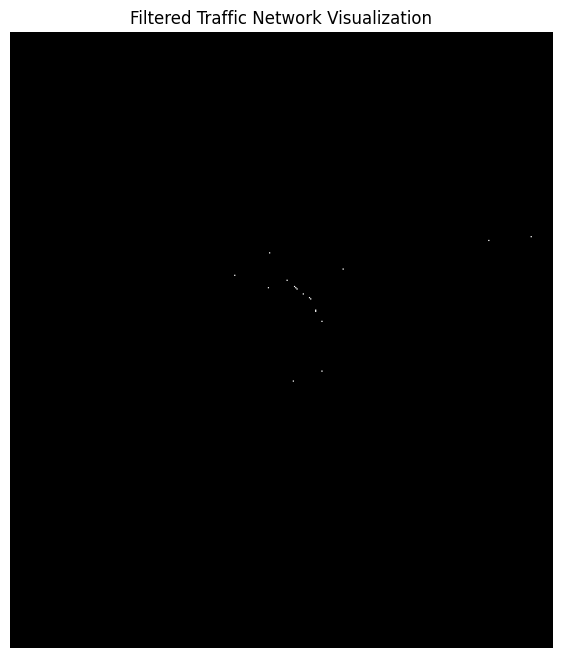

-----------------------------------------------------TrafficNetworkAnalyzer-----------------------------------------------------
Number of isolated nodes: 11
Number of nodes in the directed graph: 7, number of edges: 8
Number of nodes in the five-step graph: 7, number of edges: 10


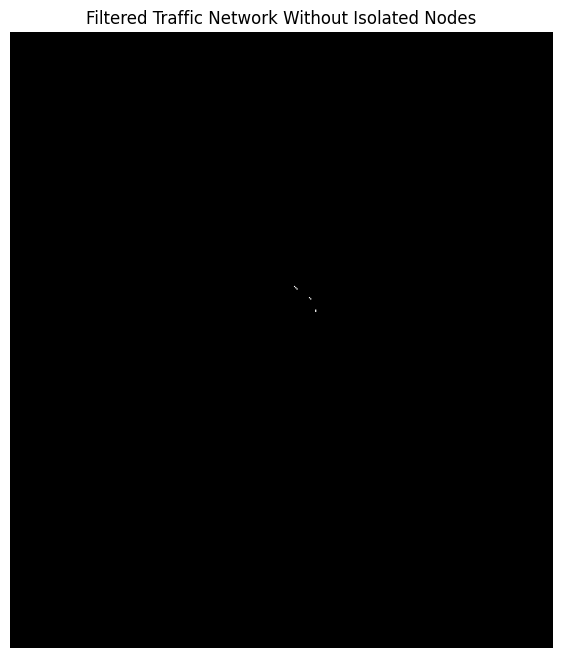

  Average Traffic Flow Statistics for Connected Nodes:
  Minimum: 42.73
  Q1 (25th percentile): 45.22
  Median (Q2, 50th percentile): 45.53
  Mean: 47.82
  Q3 (75th percentile): 49.47
  Maximum: 57.10


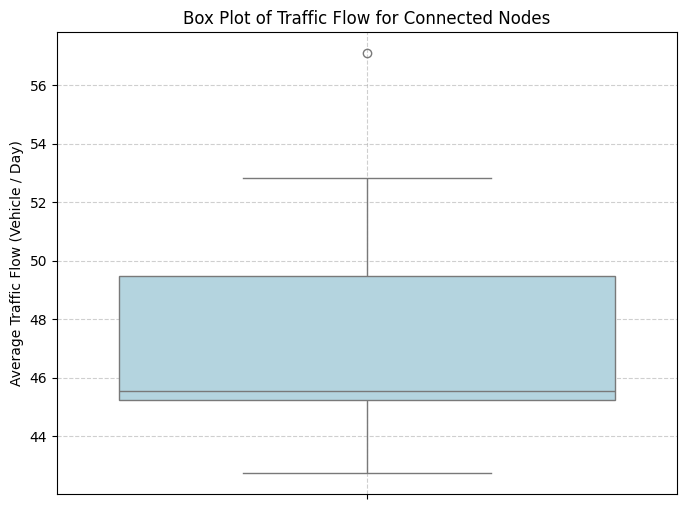

Number of nodes after flattened: 7
Number of edges after flattened: 17
-----------------------------------------------------TrafficDataProcessor-----------------------------------------------------
Shape after filtering - Main Data: (720, 7), Aux Data: (720, 7)
Computing static DTW weights...
Edge 1 processed, Time: 2.3480 sec
Edge 2 processed, Time: 2.4440 sec
Edge 3 processed, Time: 2.4914 sec
Edge 4 processed, Time: 2.4611 sec
Edge 5 processed, Time: 2.4682 sec
Edge 6 processed, Time: 2.4042 sec
Edge 7 processed, Time: 2.5051 sec
Edge 8 processed, Time: 2.4480 sec
Edge 9 processed, Time: 2.4487 sec
Edge 10 processed, Time: 2.4570 sec
Edge 11 processed, Time: 2.3671 sec
Edge 12 processed, Time: 2.3762 sec
Edge 13 processed, Time: 2.4633 sec
Edge 14 processed, Time: 2.4757 sec
Edge 15 processed, Time: 2.3779 sec
Edge 16 processed, Time: 2.3478 sec
Edge 17 processed, Time: 2.4525 sec
Static DTW graph computed.
Sliding window 1/709 generated, cost: 0.0000 sec
Sliding window 2/709 genera

In [6]:
# 使用示例
if __name__ == "__main__":
    
    file_path = "E:\\Techniche University of Munich\\master thesis\\ANTWERP\\ANTWERP\\ANTWERP_static.h5"
    analyzer = TrafficGridAnalyzer(file_path)
    analyzer.load_data()
    zero_count, zero_indices = analyzer.analyze_traffic()
    analyzer.visualize()
    print(f"Zero Count: {zero_count}")
    # print(f"Zero Count: {zero_indices}")

    march_half_filepath = r"E:\Techniche University of Munich\master thesis\ANTWERP\preprocessed_data\sliding_window\15days\30min\Antwerp_march_last_half_month_samples_30min_timesteps.txt"
    march_filepath = r"E:\Techniche University of Munich\master thesis\ANTWERP\preprocessed_data\sliding_window\15days\30min\Antwerp_march_last_half_month_samples_30min_timesteps.txt"
    march_first_half_filepath = r"E:\Techniche University of Munich\master thesis\ANTWERP\preprocessed_data\sliding_window\15days\30min\Antwerp_march_first_half_month_samples_30min_timesteps.txt"
    
    analyzer = TrafficDataAnalyzer(march_half_filepath, march_filepath)
    aux_traffic_data = analyzer.readdata(march_first_half_filepath)
    analyzer.analyze_traffic(zero_indices)
    analyzer.visualize()
    
    
    Antwerp_traffic_last_half_march = analyzer.Antwerp_traffic_last_half_march
    Antwerp_traffic_march = analyzer.Antwerp_traffic_march
    average_traffic = analyzer.average_traffic
    filtered_indices = analyzer.filtered_indices

    analyzer = TrafficNetworkAnalyzer(average_traffic, zero_indices, filtered_indices)
    analyzer.construct_graph()
    analyzer.compute_shortest_paths()
    analyzer.filter_connected_nodes()
    G_flat = analyzer.flatten_graph()

    save_dir = r"E:\Techniche University of Munich\master thesis\ANTWERP\preprocessed_data\sliding_window\15days\30min"
    history_size = 6
    forecast_size = 6
    
    processor = TrafficDataProcessor(Antwerp_traffic_last_half_march, aux_traffic_data, G_flat)
    processor.filter_and_flatten()
    processor.compute_static_dtw_graph()
    dtw_graphs = processor.save_sliding_window(save_dir, history_size=history_size, forecast_size=forecast_size)

In [7]:
aux_traffic_data.shape

(720, 495, 436)

In [17]:
dtw_graphs.nodes

NodeView((89172, 89609, 90046, 93108, 93545, 97473, 97909))

In [19]:
G_dtw = dtw_graphs  # 取出第一个滑动窗口的 DTW 图
print("Graph 1:")
node = 89172  # 假设你想找节点 68 的边权重

# 遍历该节点的所有邻居，打印边的 DTW 权重
for neighbor, data in G_dtw[node].items():
    print(f"Edge {node} - {neighbor}, DTW Weight: {data['weight']}")

Graph 1:
Edge 89172 - 89609, DTW Weight: 223.15017364994364
Edge 89172 - 90046, DTW Weight: 324.9261454546248
Edge 89172 - 89172, DTW Weight: 0.0


In [27]:
G_dtw = dtw_graphs  # 取出第一个滑动窗口的 DTW 图
print("Graph 1:")
node = 89609  # 假设你想找节点 68 的边权重

# 遍历该节点的所有邻居，打印边的 DTW 权重
for neighbor, data in G_dtw[node].items():
    print(f"Edge {node} - {neighbor}, DTW Weight: {data['weight']}")

Graph 1:
Edge 89609 - 89172, DTW Weight: 223.15017364994364
Edge 89609 - 90046, DTW Weight: 283.5507009337131
Edge 89609 - 89609, DTW Weight: 0.0


In [21]:
edge_index = torch.tensor(list(G_dtw.edges()), dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([G_dtw[u][v]['weight'] for u, v in G_dtw.edges()], dtype=torch.float)

In [23]:
print("edge_index [:, :20]:", edge_index[:, :20])
print("edge_weight [:, :20]:", edge_weight[:20])

edge_index [:, :20]: tensor([[89172, 89172, 89172, 89609, 89609, 89609, 90046, 90046, 90046, 93108,
         93108, 93545, 93545, 97473, 97473, 97909, 97909],
        [89609, 90046, 89172, 89172, 90046, 89609, 89609, 89172, 90046, 93545,
         93108, 93108, 93545, 97909, 97473, 97473, 97909]])
edge_weight [:, :20]: tensor([223.1502, 324.9261,   0.0000, 223.1502, 283.5507,   0.0000, 283.5507,
        324.9261,   0.0000, 180.6073,   0.0000, 180.6073,   0.0000, 282.3810,
          0.0000, 282.3810,   0.0000])


In [25]:
print("edge_index [:, -20:]:", edge_index[:, -20:])  # 取最后 20 条边
print("edge_weight [:, -20:]:", edge_weight[-20:])  # 取最后 20 个权重

edge_index [:, -20:]: tensor([[89172, 89172, 89172, 89609, 89609, 89609, 90046, 90046, 90046, 93108,
         93108, 93545, 93545, 97473, 97473, 97909, 97909],
        [89609, 90046, 89172, 89172, 90046, 89609, 89609, 89172, 90046, 93545,
         93108, 93108, 93545, 97909, 97473, 97473, 97909]])
edge_weight [:, -20:]: tensor([223.1502, 324.9261,   0.0000, 223.1502, 283.5507,   0.0000, 283.5507,
        324.9261,   0.0000, 180.6073,   0.0000, 180.6073,   0.0000, 282.3810,
          0.0000, 282.3810,   0.0000])
